# Lab-5
## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import glob as gb
import cv2
import keras
from tensorflow.keras.models import Sequential, Model

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:09<00:00, 44.3MB/s]
100% 346M/346M [00:09<00:00, 39.6MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/intel-image-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
trainpath = '/content/seg_train'
testpath = '/content/seg_test'
predpath = '/content/seg_pred'

In [10]:
IMAGE_SIZE = (228, 228)

BATCH_SIZE = 32

## Feature Engineering 

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 1 classes.


In [12]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3000 files belonging to 1 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['seg_train']


In [ ]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names
images_paths = getImagePaths(predpath)
len(images_paths)

7301

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

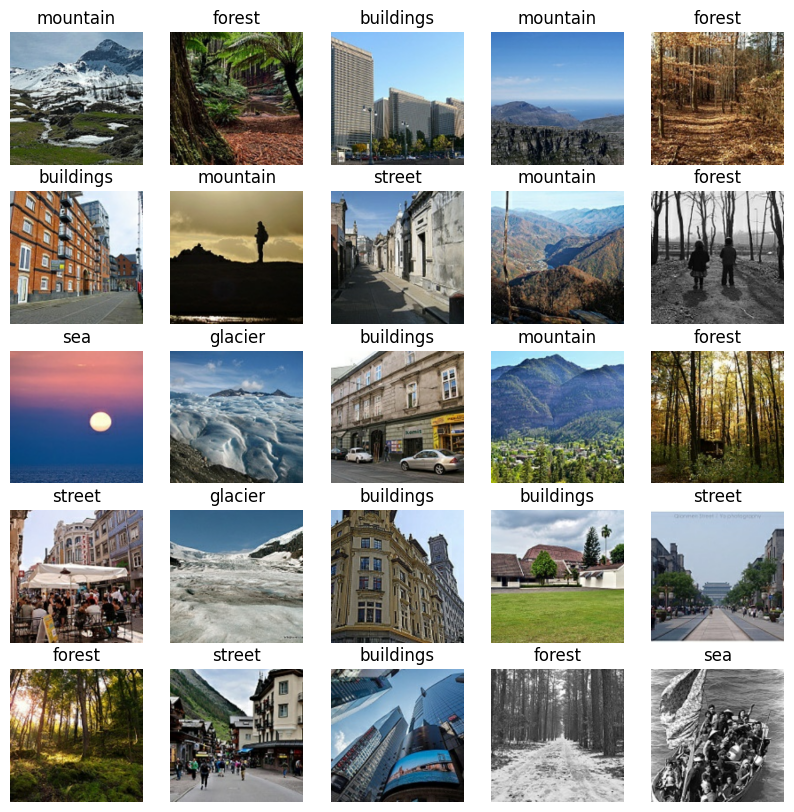

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
import tensorflow.keras.models as Models

## Model Building
### CNN
CNN stands for Convolutional Neural Network. CNNs are a class of deep neural networks that are primarily used for analyzing visual imagery.

In [ ]:
model = Models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(228,228,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

### relu
ReLU is a simple and widely used activation function. It replaces all negative input values with zero and leaves positive values unchanged.
### Softmax
Softmax is a mathematical function often used in machine learning and deep learning models, particularly in classification tasks.
### tanh
Tanh is another activation function similar to the sigmoid function, but it squashes the input values between -1 and 1. Like the sigmoid function, tanh is also used in neural networks, especially in hidden layers..
### adam(Optimizer)
Adam is an optimization algorithm used to update the weights of the neural network based on training data. It combines ideas from RMSProp (Root Mean Square Propagation) and Momentum methods.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss = "categorical_crossentropy",
    metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              verbose=1,
                              mode='min'
                             )

checkpointer = ModelCheckpoint(filepath='bestvalue.keras', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]


In [ ]:
history = model.fit(train_ds,
    validation_data=test_ds,
    epochs=40,
    callbacks=callback_list
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1706908176.326725     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 [==============================] - 39s 71ms/step - loss: 1.3536 - accuracy: 0.5281 - val_loss: 1.0239 - val_accuracy: 0.6083
Epoch 2/40
439/439 [==============================] - 19s 42ms/step - loss: 0.9009 - accuracy: 0.6574 - val_loss: 0.8130 - val_accuracy: 0.6930
Epoch 3/40
439/439 [==============================] - 19s 42ms/step - loss: 0.7748 - accuracy: 0.7103 - val_loss: 0.8169 - val_accuracy: 0.6907
Epoch 4/40
439/439 [==============================] - 19s 42ms/step - loss: 0.6703 - accuracy: 0.7502 - val_loss: 0.7356 - val_accuracy: 0.7327
Epoch 5/40
439/439 [==============================] - 24s 53ms/step - loss: 0.6002 - accuracy: 0.7833 - val_loss: 0.6191 - val_accuracy: 0.7743
Epoch 6/40
439/439 [==============================] - 25s 55ms/step - loss: 0.5384 - accuracy: 0.8086 - val_loss: 0.5917 - val_accuracy: 0.8010
Epoch 7/40
439/439 [==============================] - 26s 59ms/step - loss: 0.4915 - accuracy: 0.8217 - val_loss: 0.6742 - val_accuracy: 0.7700
Epo

## Accuracy and evaluation

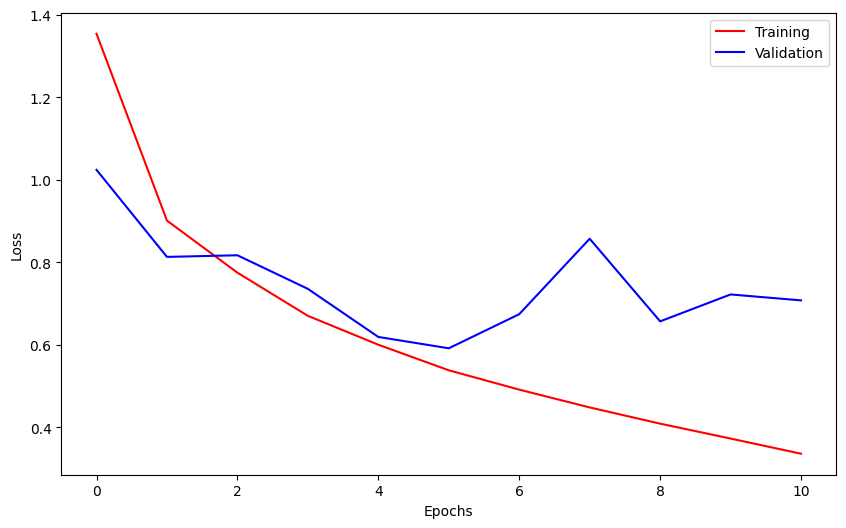

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

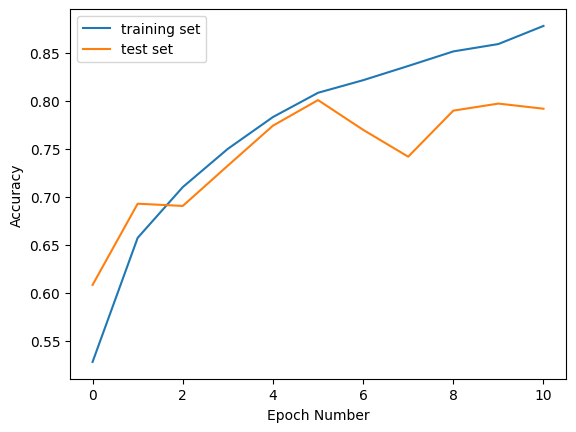

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [ ]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)

    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 22ms/step


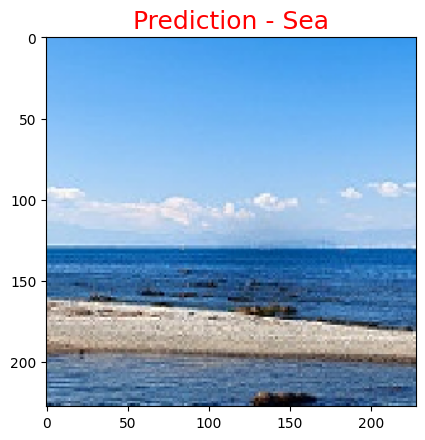

In [ ]:
from tensorflow.keras.preprocessing import image
predict_image('/kaggle/input/intel-image-classification/seg_pred/seg_pred/1003.jpg', model)